# 📘 Module 4 — Unsupervised Learning & Anomaly Detection

## Clustering • Dimensionality Reduction • Anomalies • Evaluation

In this module, we explore **unsupervised learning**, where labels are unavailable or unreliable.
Rather than predicting known outcomes, we focus on **discovering structure**, **identifying patterns**,
and **flagging unusual behavior** in data.


### Learning Objectives

By the end of this module, you should be able to:
- Explain clustering vs anomaly detection
- Apply K-Means and DBSCAN
- Use PCA and t-SNE for visualization
- Detect anomalies using multiple approaches
- Evaluate unsupervised results critically


In [1]:
# --- Imports for Module 4 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.ensemble import IsolationForest

# Dataset helper functions
from datasets_module4 import (
    make_blobs_synth,
    make_high_dim_synth,
    make_fraud_synth
)

# Consistent seed
SEED = 1955

# Load datasets
df_blobs = make_blobs_synth(seed=SEED)
df_high_dim = make_high_dim_synth(seed=SEED)
df_fraud, fraud_labels_hidden = make_fraud_synth(seed=SEED)

df_blobs.head()


,x1,x2
0,0.579667,0.071710
1,0.946514,0.743807
2,-0.986155,-0.093074
3,0.768340,0.214895
4,-0.453175,0.028567


### Interpreting the Initial Dataset Load

This cell serves two purposes:

1. **Verify that all datasets load correctly**
2. **Ground us in the structure of the data before any modeling**

The table shown above is a preview of **Dataset A (`df_blobs`)**, which contains two numeric features:
- **`x1`**
- **`x2`**

Each row represents a single observation in a 2-dimensional feature space.

#### What to notice
- Both features are **continuous** and centered near zero
- Values vary smoothly, with no obvious categorical structure
- There is no label column — this is intentional

At this stage, nothing about this table alone tells us:
- how many groups exist
- whether groups exist at all
- which points (if any) are unusual

This is a key contrast with supervised learning:  
there is **no target variable** to guide interpretation.

#### Why this matters
Unsupervised learning begins in a state of **ambiguity**.
Before we apply any algorithms, we should expect uncertainty about:
- structure
- separation
- meaning

The goal of the next sections is not to eliminate this ambiguity immediately,
but to use different methods to **probe the data from multiple angles**.

#### What this cell does *not* tell us
- It does not reveal clusters
- It does not identify anomalies
- It does not justify any modeling choice

Those insights only emerge once we:
- visualize the data
- apply clustering or anomaly detection
- compare results across methods

This cell simply confirms that the data is loaded and ready for exploration.


## 4.0 Datasets Used in This Module

Before diving into unsupervised learning methods, it is important to understand
the **role** each dataset plays in this module.

Unlike supervised learning, unsupervised learning often uses **multiple datasets**,
each designed to reveal different structural properties of data.


In [2]:
# Dataset A: Blob-like 2D data (used for clustering intuition)
df_blobs.head()


,x1,x2
0,0.579667,0.071710
1,0.946514,0.743807
2,-0.986155,-0.093074
3,0.768340,0.214895
4,-0.453175,0.028567


### Dataset A — Blob-like Clusters (`df_blobs`)

This dataset is used primarily in **Sections 4.2 and 4.3** to build intuition for
distance- and density-based clustering methods.

It consists of:
- two numeric features (`x1`, `x2`)
- unlabeled observations
- intentional noise and missing values

There are **no labels**.
Any structure we identify must be inferred from the geometry of the data.

#### Why this dataset exists

This dataset is designed to answer a simple but important question:

> *If we are given only raw features, can we tell whether meaningful groups exist at all?*

At this stage, we should **not** assume:
- how many clusters exist
- whether clusters are well separated
- whether all points belong to a group

Those assumptions will be tested — and often challenged — in later sections.

#### What this table preview tells us (and what it does not)

From the table above, we can see that:
- features are continuous and numeric
- values are centered near zero
- there is no target or class label

However, this preview does **not** reveal:
- cluster structure
- boundaries between groups
- which points might be unusual

Those insights only emerge once we visualize the data and apply clustering methods.


In [3]:
# Dataset B: High-dimensional customer-like data
df_high_dim.head()


,spend_score,engagement,income_proxy,debt_proxy,activity_rate,almost_constant
0,0.393395,0.073733,3.280334,-3.485046,2.237745,-0.062020
1,0.014538,-0.264277,6.073912,-1.934358,0.461546,-0.062961
2,1.253705,0.534656,6.494931,-2.190285,0.004321,0.026605
3,1.436881,0.945593,6.618618,-3.363339,0.789889,-0.026157
4,-1.276212,-0.564386,2.602481,-2.951514,2.122505,-0.012170


### Dataset B — High-Dimensional Customer-like Data (`df_high_dim`)

This dataset is used primarily in **Section 4.4** to illustrate why
dimensionality reduction is often necessary in unsupervised learning.

It consists of:
- multiple numeric features describing customer-like behavior
- varying feature scales
- intentional noise and subtle irregularities
- no labels or target variable

#### Why this dataset exists

This dataset is designed to highlight a common challenge:

> *Even when structure exists, it may be invisible in raw, high-dimensional data.*

From the table above, we can see that:
- many features are present simultaneously
- feature magnitudes differ across columns
- no single column clearly separates observations

Unlike Dataset A, there is **no obvious geometric intuition** here.

#### What this table preview tells us (and what it does not)

From this preview, we can confirm:
- the data is numeric and multivariate
- no labels are provided
- simple inspection does not reveal groups or anomalies

However, this table does **not** reveal:
- whether customers form meaningful segments
- whether correlations exist between features
- whether unusual behavior is present

Those questions require **projection and visualization**, not inspection.

At this stage, feeling **uncertain** about the structure is expected —
and it is precisely what motivates the next section.


In [4]:
# Dataset C: Fraud-like transaction data
df_fraud.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5
0,-0.097774,-0.081522,1.964090,-0.637891,-0.421043,1.798991
1,-0.298693,-0.330910,-1.466452,-1.060129,-0.467623,0.526437
2,2.042000,-0.305821,-0.548890,-0.232416,0.171210,-0.429921
3,-0.480770,-1.217748,-1.096023,NaN,0.791659,-0.967756
4,1.706993,1.290789,-0.086142,0.580022,0.268947,0.935176


### Dataset C — Fraud-like Transactions (`df_fraud`)

This dataset is used primarily in **Sections 4.5 and 4.6** to explore
anomaly detection in settings where labels are unavailable at decision time.

It consists of:
- multiple numeric features describing transaction behavior
- subtle variation across dimensions
- missing values and noise
- no target or class label

#### Why this dataset exists

This dataset is designed to reflect a realistic anomaly detection scenario:

> *Unusual behavior does not announce itself clearly in raw features.*

From the table above, we can see that:
- all features are numeric
- values vary across rows and columns
- missing values are present
- there is no obvious signal indicating which observations are problematic

Unlike many supervised examples, nothing in this preview clearly identifies
“fraud” or “anomaly” cases.

#### What this table preview tells us (and what it does not)

From this preview, we can confirm:
- the data is multivariate and unlabeled
- simple inspection is insufficient for decision-making

However, this table does **not** tell us:
- which observations are unusual
- how rare anomalies are
- which features are most informative
- what threshold would separate normal from abnormal behavior

Those questions require **explicit anomaly detection methods** and
careful consideration of trade-offs.

Hidden ground-truth labels exist **only for evaluation later** and are
intentionally excluded from all modeling decisions.


### Messiness Introduced (On Purpose)

All datasets in this module include:
- missing values
- noise
- imperfect structure
- ambiguous boundaries

This reflects real unsupervised learning scenarios, where:
- clean ground truth does not exist
- interpretation matters as much as metrics


### Big Picture Takeaway (Before Modeling)

Across all datasets:
- ambiguity is intentional
- noise is unavoidable
- interpretation is required

Unsupervised learning does not remove uncertainty.
It **moves uncertainty earlier** in the analysis pipeline.

As we proceed, every method should be treated as:
> *one lens on the data — not the truth.*


### What’s Next

Now that we understand the **roles** of the datasets,
we can step back and define what *unsupervised learning* actually is
and why it is used.


## 4.1 Introduction to Unsupervised Learning


In supervised learning, we are given **inputs and correct outputs**.
The goal is to learn a mapping from features to labels.

In **unsupervised learning**, labels are missing.
The goal is not prediction, but **discovery**.


### Two Core Unsupervised Tasks

Unsupervised learning methods generally fall into two categories:

**1. Clustering**
- Group similar observations together
- Assumes structure exists
- Example questions:
  - Are there natural customer segments?
  - Do these samples form distinct groups?

**2. Anomaly Detection**
- Identify rare or unusual observations
- Assumes most data are “normal”
- Example questions:
  - Which transactions look suspicious?
  - Which sensors are behaving abnormally?


### Why Labels Are Often Unavailable

In many real-world settings:
- labeling is expensive
- labeling is slow
- labeling requires expert judgment
- labels may change over time

As a result, unsupervised methods are often used:
- for early exploration
- as monitoring tools
- to prioritize human attention


### Important Caveat

Unsupervised learning **does not tell you what is correct**.
It tells you what the data *suggests*.

Because of this:
- results require interpretation
- multiple methods may disagree
- visual inspection is often essential


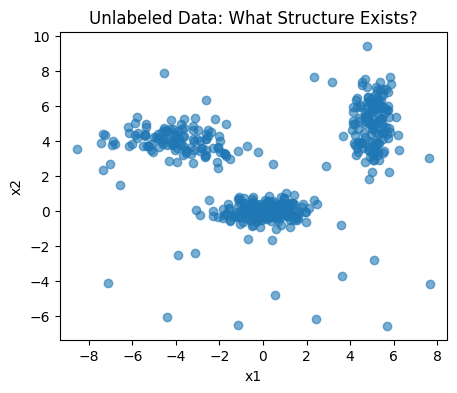

In [5]:
# Visualizing raw data before any modeling
plt.figure(figsize=(5, 4))
plt.scatter(df_blobs["x1"], df_blobs["x2"], alpha=0.6)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Unlabeled Data: What Structure Exists?")
plt.show()


### Interpreting the Unlabeled Scatter Plot

This plot shows the raw data from **Dataset A (`df_blobs`)**, visualized in its original
two-dimensional feature space (`x1` vs `x2`).

At this point:
- there are **no labels**
- no clustering algorithm has been applied
- no assumptions have been enforced by a model

We are simply asking:
> *What structure, if any, appears to exist in the data?*

#### What to notice

Several patterns are visually apparent:

- Points appear to form **multiple dense regions**
- Some regions are compact, while others are more spread out
- A small number of points lie **far from any dense region**
- Boundaries between groups are **not perfectly clean**

Even without any algorithm, our visual system begins to suggest
that the data may not be uniformly distributed.

#### Why this matters

This plot highlights an important idea in unsupervised learning:

> *Structure can be suggested by the data, but it is not explicitly defined.*

At this stage:
- we do not know how many groups exist
- we do not know whether these apparent groupings are meaningful
- we do not know whether isolated points are true anomalies or noise

Different unsupervised methods will **interpret this same structure differently**,
depending on their assumptions.

#### What this visualization does *not* tell us

Despite its usefulness, this plot does **not** answer several critical questions:

- Are these groups stable or an artifact of scale?
- Should every point belong to a group?
- Are isolated points errors, anomalies, or legitimate observations?
- How sensitive are these patterns to parameter choices?

Answering those questions requires applying models —
and understanding the assumptions those models make.

#### Big picture takeaway

This visualization sets the stage for the rest of the module.

Unsupervised learning begins with **intuition**, not certainty.
The goal of the next sections is to:
- formalize these visual impressions
- test them using different methods
- and critically evaluate how much trust they deserve



In the next sections, we will begin with **simple clustering methods**
and gradually build intuition before introducing more complex tools.

## 4.2 Clustering with K-Means

K-Means is one of the simplest and most widely used clustering algorithms.
It provides a useful **baseline** for understanding how clustering works — and
why it sometimes fails.


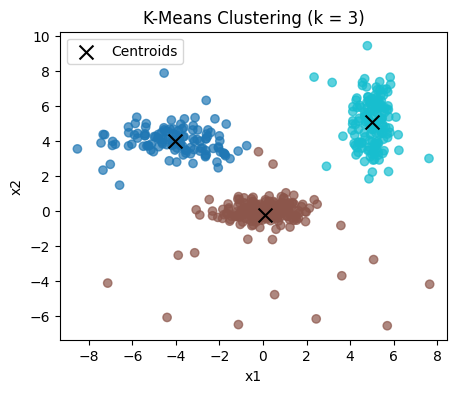

In [6]:
# Prepare data (drop missing values for now)
X = df_blobs.dropna().values

# Fit K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=SEED)
labels = kmeans.fit_predict(X)

# Plot clustering result
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c="black",
    s=100,
    marker="x",
    label="Centroids"
)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("K-Means Clustering (k = 3)")
plt.legend()
plt.show()


### Interpreting the First K-Means Result (k = 3)

This plot shows the result of applying **K-Means clustering with `k = 3`** to the same
unlabeled data we visualized in Section 4.1.

Each point is now colored according to its assigned cluster, and the black “X” markers
indicate the **cluster centroids** learned by the algorithm.

#### What to notice

Several things stand out immediately:

- The dense regions we *suspected* earlier are now explicitly separated into clusters
- Each cluster has a clear center, around which points are grouped
- The clusters appear roughly compact and elliptical in shape
- **Every point has been assigned to a cluster**, even those that look isolated

Compared to the raw scatter plot, K-Means has imposed a much clearer structure on the data.

#### Why this happens

K-Means is a **distance-based, center-seeking** algorithm.

It:
- places `k` centroids in the feature space
- assigns each point to the nearest centroid
- updates centroids to the mean of assigned points

As a result:
- clusters tend to be **spherical or elliptical**
- cluster boundaries are defined by distance, not density
- points far from dense regions are still forced into the nearest cluster

This explains why even visually isolated points are absorbed into one of the three groups.

#### What this result does *not* tell us

Although the clustering looks clean, several questions remain unanswered:

- Is `k = 3` the “right” number of clusters?
- Are all points equally well represented by their assigned cluster?
- Should isolated points really belong to any cluster at all?
- How sensitive is this result to feature scaling or parameter choices?

K-Means gives us **one possible interpretation** of the structure —
but not a guarantee that this interpretation is meaningful.

#### Big picture takeaway

K-Means has transformed a vague visual impression into a concrete grouping.
However, it does so by making **strong assumptions** about cluster shape and membership.

In the next steps, we will:
- examine how changing `k` alters this picture
- explore how scaling affects distance-based clustering
- and eventually compare K-Means to methods that *do not* force every point into a cluster


### How does K-Means work?
K-Means works by:
1. Choosing `k` cluster centers
2. Assigning each point to the nearest center
3. Updating centers to the mean of assigned points
4. Repeating until assignments stabilize

This means K-Means is fundamentally **distance-based** and **center-seeking**.


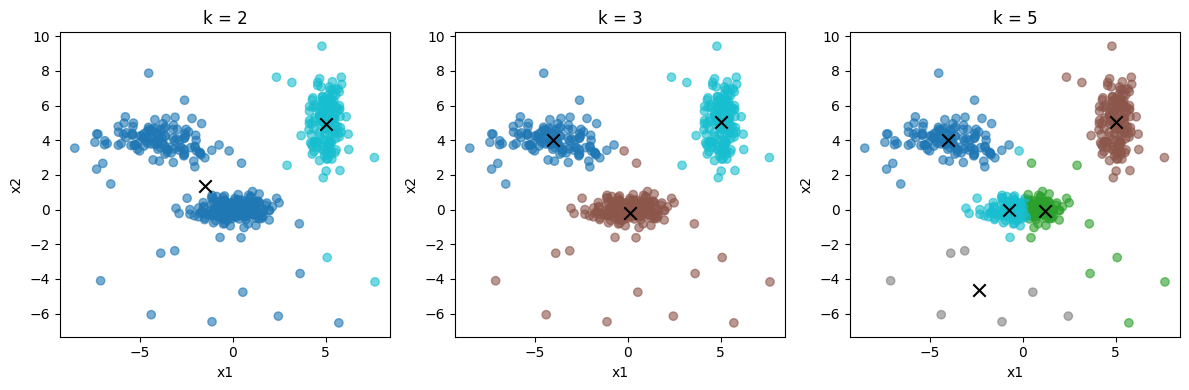

In [7]:
# Compare different values of k
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, k in zip(axes, [2, 3, 5]):
    km = KMeans(n_clusters=k, random_state=SEED)
    lbls = km.fit_predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=lbls, cmap="tab10", alpha=0.6)
    ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
               c="black", s=80, marker="x")
    ax.set_title(f"k = {k}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.tight_layout()
plt.show()


### Interpreting the Effect of Changing `k`

This figure shows how **K-Means clustering changes as we vary the number of clusters `k`**.
The same data is clustered three times, with `k = 2`, `k = 3`, and `k = 5`.

Each panel uses the same axes and scale, allowing direct comparison.

#### What to notice

- **`k = 2`**
  - Two dense regions are merged into a single cluster
  - Distinct groups are forced together
  - The centroid lies between substructures rather than at a natural center

- **`k = 3`**
  - The clusters align closely with the visually apparent dense regions
  - Each group has a well-placed centroid
  - This value of `k` feels “reasonable” given the data geometry

- **`k = 5`**
  - Some clusters are split into smaller subgroups
  - Centroids appear closer together
  - Isolated points influence centroid placement more strongly

As `k` increases, K-Means does not discover *new* structure —
it **subdivides existing structure**.

#### Why this happens

K-Means is designed to minimize **within-cluster distance**.
Increasing `k` gives the algorithm more flexibility to:
- reduce average distance to centroids
- fit finer partitions of the data

However, lower distance does **not** necessarily imply better meaning.

The algorithm has no notion of:
- “natural” groups
- interpretability
- whether splitting a cluster is useful

It only knows distance.

#### What this tells us about choosing `k`

There is no universally correct value of `k`.

Instead:
- small `k` risks **over-merging** distinct groups
- large `k` risks **over-fragmenting** meaningful structure

Choosing `k` is therefore:
- a modeling decision
- a domain decision
- not purely a mathematical one

This is a recurring theme in unsupervised learning.

#### Big picture takeaway

Changing `k` changes the *story* K-Means tells about the data.

K-Means does not reveal the “true” number of clusters —
it reflects the assumptions we impose.

This limitation motivates:
- careful parameter tuning
- the use of evaluation heuristics
- and alternative methods that do not require specifying `k` in advance


### Why Choosing `k` Matters

- Too small `k` → distinct groups get merged
- Too large `k` → clusters are artificially split

K-Means **requires you to decide `k` in advance**.
This is both a strength (simplicity) and a limitation.


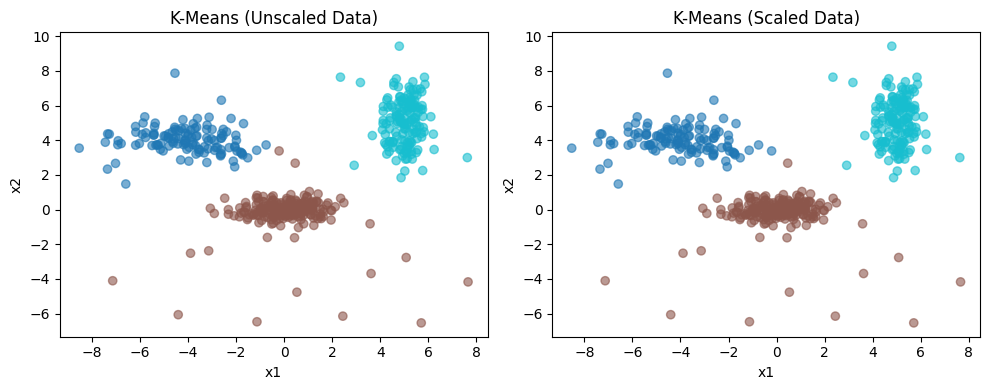

In [8]:
# Demonstrate the effect of feature scaling
X_unscaled = X.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

km_unscaled = KMeans(n_clusters=3, random_state=SEED).fit_predict(X_unscaled)
km_scaled = KMeans(n_clusters=3, random_state=SEED).fit_predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X_unscaled[:, 0], X_unscaled[:, 1], c=km_unscaled, cmap="tab10", alpha=0.6)
axes[0].set_title("K-Means (Unscaled Data)")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

axes[1].scatter(X_unscaled[:, 0], X_unscaled[:, 1], c=km_scaled, cmap="tab10", alpha=0.6)
axes[1].set_title("K-Means (Scaled Data)")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")

plt.tight_layout()
plt.show()


### Interpreting the Effect of Feature Scaling

This figure compares the results of K-Means clustering on the **same data**:
- once using the **original (unscaled) features**
- once after **standardizing the features**

The number of clusters `k` is the same in both cases.

#### What to notice

At first glance, the two plots may look similar.
However, there are subtle but important differences:

- Cluster boundaries shift slightly after scaling
- Some points change cluster assignment
- Centroid locations move when features are rescaled

Even though the geometry of the data appears visually similar,
the algorithm’s *distance calculations* are not.

#### Why this happens

K-Means relies on **Euclidean distance**.

Without scaling:
- features with larger numeric ranges dominate distance calculations
- smaller-scale features have less influence, regardless of importance

With scaling:
- each feature contributes more equally
- distances better reflect *relative variation* rather than raw magnitude

The algorithm itself has not changed —
only the **representation of the data** has.

#### What this tells us

The results of K-Means depend not only on:
- the choice of `k`
- the clustering algorithm

but also on:
- how features are measured
- how they are preprocessed

This means clustering outcomes can change
*without changing the data itself* —
only our representation of it.


### Why Scaling Matters

K-Means relies on **Euclidean distance**.
Features with larger numeric ranges can dominate distance calculations.

As a result:
- unscaled data may lead to misleading clusters
- scaling often changes cluster assignments significantly

This is not a bug — it reflects the assumptions K-Means makes.


### Key Limitations of K-Means

K-Means tends to work best when:
- clusters are roughly spherical
- clusters have similar sizes
- noise is minimal

It struggles when:
- clusters have irregular shapes
- densities vary
- noise or outliers are present

In the next section, we will introduce **density-based clustering**
to address these limitations.


## 4.3 DBSCAN and Density-Based Clustering

K-Means assumes clusters are **centered and spherical**.
DBSCAN takes a very different approach:
it defines clusters as **dense regions of points** separated by sparse areas.


In [9]:
# Prepare data (drop missing values for consistency)
X = df_blobs.dropna().values

# Scale features (important for distance-based density)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Preparing the Data for DBSCAN

Before applying DBSCAN, we perform two preprocessing steps:

1. **Drop missing values**  
   DBSCAN relies on distance calculations and does not handle missing values directly.
   For consistency and clarity, we remove rows with missing entries at this stage.

2. **Scale the features**  
   DBSCAN is a **distance-based, density-based** method.
   If features are on different scales, density estimates become distorted.

Unlike K-Means, scaling is not just recommended for DBSCAN —
it is often **essential** for meaningful results.

At this point, no clustering has been performed.
We are simply ensuring the data representation aligns with the assumptions
of the algorithm we are about to apply.


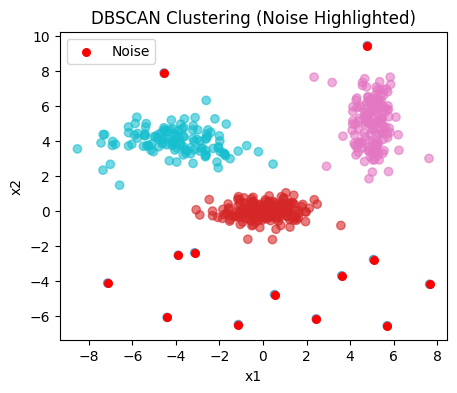

In [10]:
# Run DBSCAN with a reasonable parameter choice
dbscan = DBSCAN(eps=0.6, min_samples=8)
labels_db = dbscan.fit_predict(X_scaled)

# Identify noise points (label = -1)
is_noise = labels_db == -1

# Plot DBSCAN result
plt.figure(figsize=(5, 4))
plt.scatter(
    X[:, 0], X[:, 1],
    c=labels_db,
    cmap="tab10",
    alpha=0.6
)

# Highlight noise points
plt.scatter(
    X[is_noise, 0], X[is_noise, 1],
    c="red",
    s=30,
    label="Noise"
)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("DBSCAN Clustering (Noise Highlighted)")
plt.legend()
plt.show()


### Interpreting the DBSCAN Clustering Result

This plot shows the result of applying **DBSCAN** to the same dataset used in K-Means,
with **noise points explicitly highlighted**.

Unlike K-Means, DBSCAN does not assign every point to a cluster.

#### What to notice

Several key differences from K-Means are immediately visible:

- Dense regions are grouped into clusters **without enforcing a fixed number**
- Some points are labeled as **noise** and left unassigned
- Clusters can have irregular shapes
- Isolated points are no longer forced into the nearest group

Points highlighted as noise tend to:
- lie far from dense regions, or
- fall in low-density areas between clusters

#### Why this happens

DBSCAN defines clusters based on **local point density**, not distance to a center.

A point is assigned to a cluster only if:
- it has enough nearby neighbors, and
- those neighbors form a connected dense region

Points that do not meet these criteria are labeled as noise.

This makes DBSCAN fundamentally different from K-Means:
- K-Means asks *“Which center is closest?”*
- DBSCAN asks *“Is this point part of a dense region at all?”*

#### What this result tells us

DBSCAN is particularly useful when:
- cluster shapes are irregular
- outliers are meaningful
- forcing every point into a cluster is undesirable

However, the result still depends on parameter choices,
which we will explore next.

#### Big picture takeaway

DBSCAN offers a **more cautious interpretation** of structure:
it clusters only where density justifies it and explicitly acknowledges uncertainty
by labeling some points as noise.

This makes it a natural complement to K-Means,
not a replacement.


### How DBSCAN Works (Conceptually)

DBSCAN defines clusters using two ideas:
- **Density**: points with many nearby neighbors belong together
- **Connectivity**: dense regions can grow outward

Points that do not belong to any dense region are labeled as **noise**.
Unlike K-Means, DBSCAN:
- does *not* require choosing `k`
- can discover irregular cluster shapes
- explicitly identifies outliers


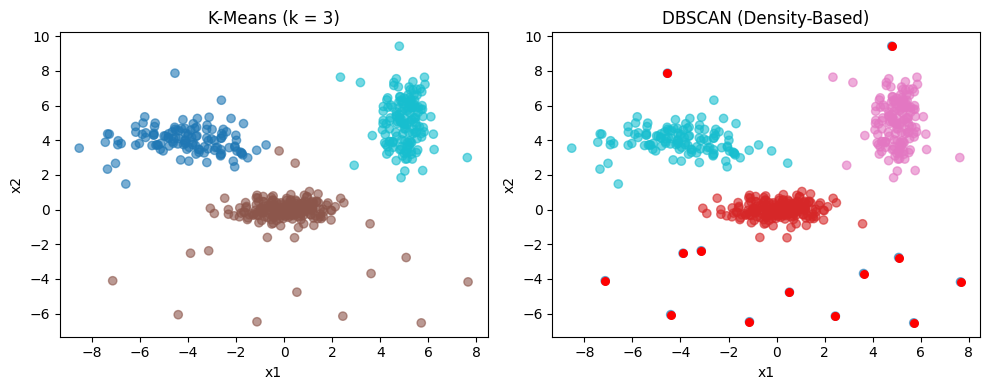

In [11]:
# Compare K-Means and DBSCAN side by side
kmeans = KMeans(n_clusters=3, random_state=SEED)
labels_km = kmeans.fit_predict(X)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X[:, 0], X[:, 1], c=labels_km, cmap="tab10", alpha=0.6)
axes[0].set_title("K-Means (k = 3)")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

axes[1].scatter(X[:, 0], X[:, 1], c=labels_db, cmap="tab10", alpha=0.6)
axes[1].scatter(X[is_noise, 0], X[is_noise, 1], c="red", s=30)
axes[1].set_title("DBSCAN (Density-Based)")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")

plt.tight_layout()
plt.show()


### Interpreting K-Means vs. DBSCAN Side by Side

This figure compares the results of **K-Means (k = 3)** and **DBSCAN**
applied to the *same dataset*, using the *same feature space*.

Both methods are clustering the same points — the differences come entirely
from their assumptions.

#### What to notice

Several contrasts are immediately visible:

- **K-Means**
  - Assigns every point to a cluster
  - Produces compact, center-based groups
  - Absorbs isolated points into the nearest cluster

- **DBSCAN**
  - Forms clusters only where density is sufficient
  - Leaves some points explicitly labeled as **noise**
  - Does not force low-density points into any group

Points highlighted as noise under DBSCAN are often:
- far from dense regions, or
- located in sparse areas between clusters

These same points are still assigned to clusters by K-Means.

#### Why the results differ

The two algorithms are answering fundamentally different questions:

- **K-Means** asks:
  > *Which cluster center is closest?*

- **DBSCAN** asks:
  > *Is this point part of a dense region at all?*

As a result:
- K-Means prioritizes **global structure**
- DBSCAN prioritizes **local density**

Neither approach is “more correct” —
they reflect different modeling philosophies.

#### What this comparison tells us

This comparison highlights a key decision in unsupervised learning:

> *Should every observation be grouped, or should some remain unassigned?*

- If all points must belong to a group → K-Means may be appropriate
- If outliers are meaningful and uncertainty matters → DBSCAN may be preferable

This distinction becomes especially important in applications
like anomaly detection and monitoring.

#### Big picture takeaway

DBSCAN does not replace K-Means.
It **complements** it by offering a more conservative interpretation of structure.

Together, these methods show that:
- clustering results depend on assumptions
- different algorithms surface different aspects of the data
- interpretation is unavoidable


### What Changed?

- K-Means forces **every point** into a cluster
- DBSCAN allows some points to be **unassigned (noise)**

This makes DBSCAN especially useful when:
- outliers are meaningful
- cluster shapes are irregular
- densities vary across the dataset


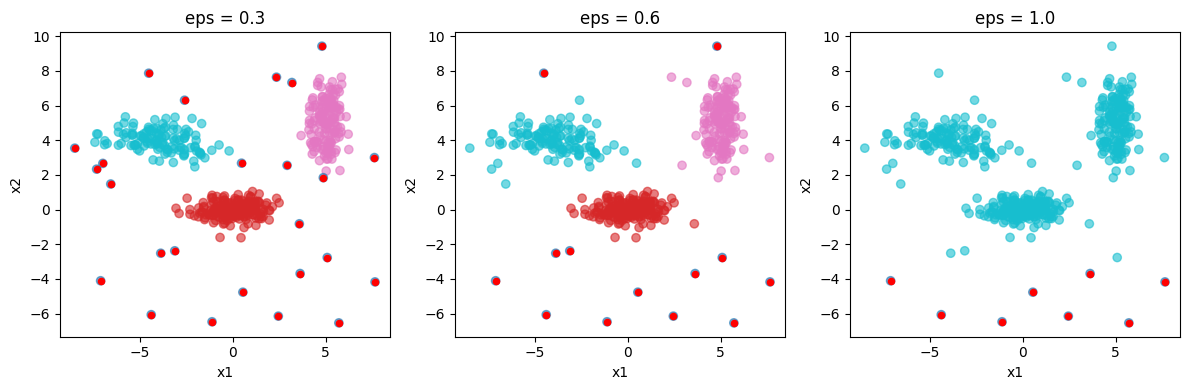

In [12]:
# Show sensitivity to eps parameter
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, eps in zip(axes, [0.3, 0.6, 1.0]):
    db = DBSCAN(eps=eps, min_samples=8)
    lbls = db.fit_predict(X_scaled)
    noise = lbls == -1

    ax.scatter(X[:, 0], X[:, 1], c=lbls, cmap="tab10", alpha=0.6)
    ax.scatter(X[noise, 0], X[noise, 1], c="red", s=20)
    ax.set_title(f"eps = {eps}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.tight_layout()
plt.show()


### Interpreting DBSCAN Sensitivity to `eps`

This figure shows how **DBSCAN’s clustering behavior changes as we vary the `eps` parameter**,
while keeping all other settings fixed.

Recall that `eps` defines the **radius of the neighborhood** used to determine local density.

#### What to notice

- **`eps = 0.3`**
  - Very few points meet the density requirement
  - Many points are labeled as **noise**
  - Only the densest cores form clusters

- **`eps = 0.6`**
  - Dense regions are grouped into clear clusters
  - Noise points are mostly isolated outliers
  - This setting balances cluster formation and noise detection

- **`eps = 1.0`**
  - Neighborhoods grow large enough to connect separate regions
  - Previously distinct clusters begin to merge
  - Very few points remain labeled as noise

As `eps` increases, DBSCAN becomes **less selective** about what counts as a dense region.

#### Why this happens

DBSCAN defines density locally:
- a point belongs to a cluster only if enough neighbors fall within `eps`
- increasing `eps` increases the chance that points are considered connected

This means:
- small `eps` → strict density requirement → more noise
- large `eps` → loose density requirement → fewer clusters, less noise

The algorithm itself has not changed —
only our definition of *“nearby.”*

#### What this tells us about DBSCAN

Unlike K-Means, DBSCAN does not require choosing `k`,
but it **does require careful parameter selection**.

There is no universally correct value of `eps`.
Instead, the choice depends on:
- data scale
- point density
- how cautious you want the clustering to be

#### Big picture takeaway

DBSCAN trades one type of subjectivity for another:
- it avoids specifying the number of clusters
- but introduces sensitivity to density parameters

This reinforces a core lesson of unsupervised learning:
**assumptions never disappear — they only change form.**


### Parameter Sensitivity

DBSCAN does not require `k`, but it **does** require careful parameter tuning.

- `eps` too small → most points labeled as noise
- `eps` too large → distinct clusters merge
- `min_samples` controls how dense a region must be to form a cluster

There is no universally correct setting — parameters depend on:
- feature scaling
- data density
- domain context


### Key Takeaways

- DBSCAN groups points by **density**, not proximity to a center
- It can find clusters K-Means cannot
- Noise points are an explicit output, not a failure
- Parameter choices strongly affect results

Next, we move to **dimensionality reduction** to understand how
structure and anomalies appear in high-dimensional data.


## 4.4 Dimensionality Reduction

Many real-world datasets have **dozens or hundreds of features**.
While models can operate in high dimensions, humans cannot easily reason about them.

Dimensionality reduction helps us:
- visualize complex structure
- detect clusters and anomalies
- reduce noise and redundancy

In this section, we focus on **visual intuition**, not modeling performance.


Before reducing dimensions, we:
- handle missing values (temporarily)
- scale features so no single feature dominates distance

This preprocessing is **not about optimal modeling** —
it is about making visual comparisons meaningful.


In [13]:
# Prepare high-dimensional data
X_hd = df_high_dim.copy()

# Simple handling of missing values for visualization
X_hd = X_hd.fillna(X_hd.mean())

# Scale features
scaler = StandardScaler()
X_hd_scaled = scaler.fit_transform(X_hd)


### Preparing High-Dimensional Data for Projection

Before applying dimensionality reduction, we perform three preprocessing steps:

1. **Create a working copy of the data**  
   This allows us to modify the dataset without altering the original table.

2. **Handle missing values**  
   PCA and other projection methods do not handle missing values directly.
   Here, we use simple mean imputation *only for visualization purposes*.

3. **Scale the features**  
   PCA is sensitive to feature scale.
   Without scaling, features with larger numeric ranges would dominate
   the projection, regardless of their informational value.

At this stage, we are **not modeling** or making decisions.
We are ensuring that the data representation aligns with the assumptions
of the projection method we are about to use.


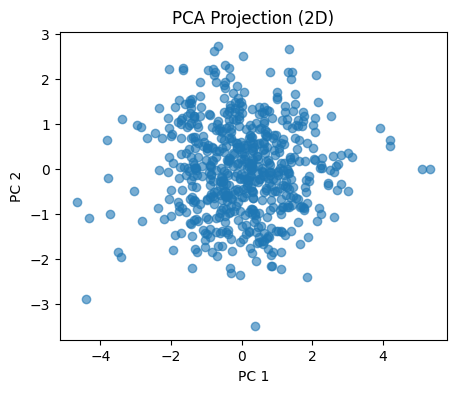

array([0.28492973, 0.17324429])

In [14]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_hd_scaled)

# Plot PCA result
plt.figure(figsize=(5, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Projection (2D)")
plt.show()

# Explained variance
pca.explained_variance_ratio_


### Interpreting the PCA Projection (2D)

This plot shows the result of applying **Principal Component Analysis (PCA)**
to the high-dimensional dataset and projecting it into **two dimensions**.

Each point represents the same observation as before,
but now positioned using:
- **PC 1** — the direction of greatest variance
- **PC 2** — the direction of second-greatest variance

#### What to notice

Several features of this projection stand out:

- The points form a **dense, roughly circular cloud**
- No obvious, well-separated clusters appear
- There are no clear gaps that would suggest natural group boundaries
- Most points lie near the center, with a few spread farther out

This is very different from the structure we saw in the original 2D blob dataset.

#### Why this happens

PCA is a **linear projection method**.
It prioritizes preserving **overall variance**, not cluster separation.

As a result:
- If meaningful structure is aligned with variance, PCA can reveal it
- If structure is subtle or nonlinear, PCA may compress it into overlap

In this case, PCA suggests that:
- variance is spread across multiple directions
- no single projection cleanly separates groups

#### What the explained variance tells us

The explained variance ratio indicates how much information
each principal component retains.

Even if PC 1 and PC 2 capture a reasonable fraction of total variance,
that does **not** guarantee that clusters or anomalies will be visible.

Variance preservation and separability are related —
but they are not the same thing.

#### Big picture takeaway

This PCA projection reinforces a key lesson:

> *High-dimensional structure can exist even when 2D projections look ambiguous.*

PCA is a valuable **diagnostic tool**, but:
- it does not confirm the absence of structure
- it does not replace clustering or anomaly detection

In the next step, we will apply a **nonlinear projection method**
to see whether local structure becomes more visible.


### t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE is designed for **visualization**, not modeling.

Key characteristics:
- nonlinear
- preserves *local* neighborhoods
- distances between far-apart points are not meaningful

t-SNE often reveals clusters more clearly —
but can also **invent visual separation**.


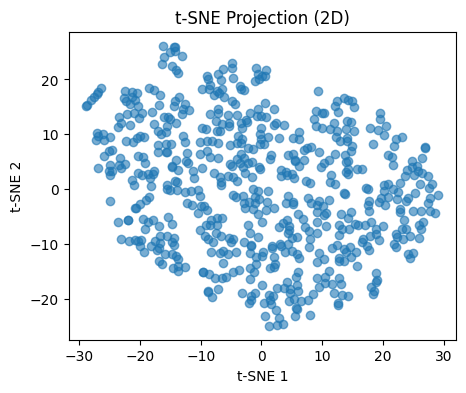

In [15]:
# Apply t-SNE for nonlinear visualization
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=SEED
)

X_tsne = tsne.fit_transform(X_hd_scaled)

# Plot t-SNE result
plt.figure(figsize=(5, 4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Projection (2D)")
plt.show()


### Interpreting the t-SNE Projection (2D)

This plot shows the result of applying **t-SNE** to the same high-dimensional dataset,
projected into two dimensions.

Unlike PCA, t-SNE is a **nonlinear visualization method** designed to preserve
*local neighborhood structure* rather than global variance.

#### What to notice

Several features stand out in this projection:

- Points are spread across the space with **no obvious global structure**
- There are **local pockets of nearby points**, but no clear, stable clusters
- The overall shape appears irregular and warped
- Distances between far-apart points are difficult to interpret

Compared to the PCA projection, this visualization feels more “stretched” and less compact.

#### Why this happens

t-SNE prioritizes **local similarity**:
- points that are close in the original space tend to remain close
- points that are far apart may be placed arbitrarily

As a result:
- local groupings may appear more pronounced
- global geometry is intentionally distorted
- apparent separation does not necessarily imply meaningful clusters

This is a feature of t-SNE — not a flaw.

#### How this compares to PCA

- **PCA** preserves global variance but may hide subtle structure
- **t-SNE** emphasizes local neighborhoods but sacrifices global meaning

In this case:
- PCA suggested no strong variance-aligned structure
- t-SNE suggests some local organization, but without clear boundaries

The two methods are not contradicting each other —
they are answering **different questions**.

#### What this visualization does *not* tell us

Despite its visual appeal, this plot does **not** tell us:
- how many clusters exist
- whether any clusters are meaningful
- whether apparent gaps are stable or parameter-dependent

t-SNE is best used to **generate hypotheses**, not confirm them.

#### Big picture takeaway

t-SNE reminds us that:
> *Seeing separation is not the same as understanding structure.*

Dimensionality reduction is a **diagnostic lens**, not a decision rule.
To understand whether patterns are meaningful, we must combine:
- multiple visualizations
- clustering methods
- anomaly detection
- and domain context


### PCA vs t-SNE — How to Think About the Difference

- **PCA**
  - interpretable
  - stable
  - good for variance analysis
  - may hide nonlinear structure

- **t-SNE**
  - excellent for visualization
  - sensitive to parameters
  - not suitable for downstream modeling

Neither method reveals “the truth” —
they provide **different lenses** on the same data.


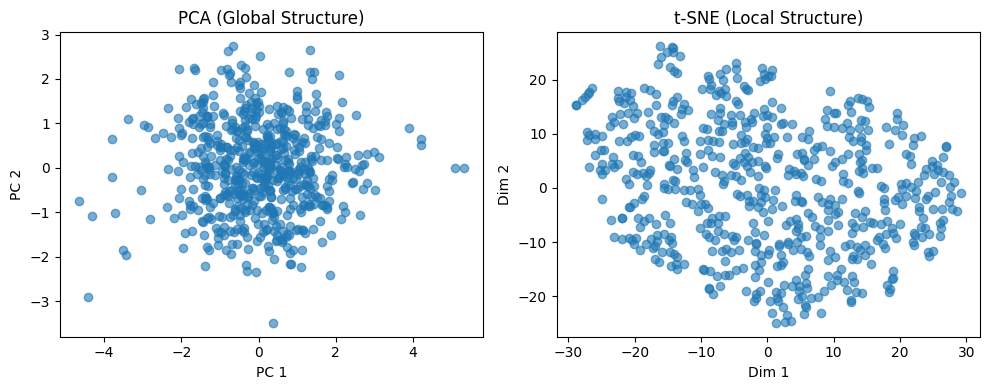

In [16]:
# Compare PCA and t-SNE side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
axes[0].set_title("PCA (Global Structure)")
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
axes[1].set_title("t-SNE (Local Structure)")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

plt.tight_layout()
plt.show()


### Comparing PCA and t-SNE: Global vs. Local Structure

This figure places **PCA** and **t-SNE** side by side, using the same dataset and
the same underlying observations.

Although both methods reduce the data to two dimensions, they are designed
to preserve **different aspects of structure**.

#### What to notice

- **PCA (left)**
  - Produces a compact, roughly symmetric cloud
  - Preserves overall variance and global geometry
  - Does not reveal obvious cluster separation

- **t-SNE (right)**
  - Produces a stretched, irregular layout
  - Emphasizes local neighborhoods
  - Suggests pockets of nearby points, but without clear boundaries

The two projections look very different — even though they come from the same data.

#### Why these views differ

PCA and t-SNE are answering **different questions**:

- **PCA asks:**  
  *“Along which directions does the data vary the most overall?”*

- **t-SNE asks:**  
  *“Which points are close to each other locally?”*

Because of this:
- PCA preserves **global structure**, even if it hides local detail
- t-SNE preserves **local structure**, even if it distorts global relationships

Neither view is more “correct” — they reflect different priorities.

#### How to interpret disagreement

When PCA and t-SNE disagree:
- it does **not** mean one method failed
- it means structure depends on *what you choose to preserve*

This is a common situation in real data:
- global variance may not align with meaningful groups
- local similarity may exist without forming clean clusters

#### Practical takeaway

Dimensionality reduction should be used as a **diagnostic tool**, not a decision rule.

Good practice involves:
- comparing multiple projections
- checking consistency across methods
- resisting the urge to overinterpret visual separation

In the next section, we will move beyond visualization and apply
**explicit anomaly detection methods**, using these projections only
to help interpret their results.


### Why This Matters for Anomaly Detection

Clusters and anomalies often become **visible only after projection**.

In the next section, we will:
- overlay anomaly detection results
- examine false positives vs false negatives
- discuss trade-offs in real decision-making

Dimensionality reduction will serve as a **diagnostic tool**, not a decision rule.


## 4.5a Classical Anomaly Detection

Classical anomaly detection methods assume:
- most data points are *normal*
- anomalies are *rare* and *different*

These methods do **not** require labeled anomalies.
Instead, they assign each point an **anomaly score**.


In [17]:
# Prepare fraud-like dataset
X_fraud = df_fraud.copy()

# Temporary handling of missing values
X_fraud = X_fraud.fillna(X_fraud.mean())

# Scale features
scaler = StandardScaler()
X_fraud_scaled = scaler.fit_transform(X_fraud)


Before fitting an anomaly detection model, we:
- handle missing values
- scale features

This preprocessing mirrors real workflows, where
clean labels are unavailable but reasonable defaults are needed.


In [18]:
# Fit Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination=0.03,
    random_state=SEED
)

iso.fit(X_fraud_scaled)

# Anomaly scores (lower = more anomalous)
scores = iso.decision_function(X_fraud_scaled)

# Binary predictions: -1 = anomaly, 1 = normal
preds = iso.predict(X_fraud_scaled)


### Isolation Forest Intuition

Isolation Forest works by:
- randomly partitioning the data
- measuring how quickly points become isolated

Anomalies:
- tend to be isolated *quickly*
- receive lower anomaly scores


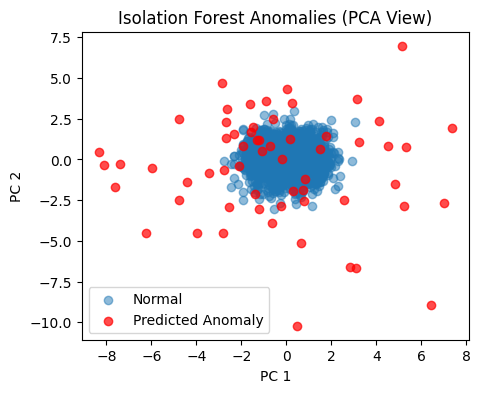

In [19]:
# Project fraud data to 2D for visualization
pca = PCA(n_components=2, random_state=SEED)
X_fraud_pca = pca.fit_transform(X_fraud_scaled)

# Identify predicted anomalies
is_anomaly = preds == -1

plt.figure(figsize=(5, 4))
plt.scatter(
    X_fraud_pca[~is_anomaly, 0],
    X_fraud_pca[~is_anomaly, 1],
    alpha=0.5,
    label="Normal"
)
plt.scatter(
    X_fraud_pca[is_anomaly, 0],
    X_fraud_pca[is_anomaly, 1],
    c="red",
    alpha=0.7,
    label="Predicted Anomaly"
)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Isolation Forest Anomalies (PCA View)")
plt.legend()
plt.show()


### Interpreting Isolation Forest Anomalies (PCA View)

This plot shows the output of an **Isolation Forest** applied to the dataset,
with results visualized in **PCA space**.

- **Blue points** represent observations classified as *normal*
- **Red points** represent observations flagged as *anomalies*

Importantly, the anomaly detection was performed in the **original feature space**.
The PCA projection is used here **only to help us interpret the results**.

#### What to notice

Several patterns stand out:

- Many anomalies lie **on the fringes** of the dense central region
- Some anomalies appear **far from the bulk of the data**
- A small number of anomalies overlap with regions of higher density
- The boundary between “normal” and “anomalous” is **not sharp**

This immediately suggests that anomaly detection is **not a simple geometric cutoff**.

#### Why this happens

Isolation Forest works by:
- randomly partitioning the feature space
- measuring how quickly individual points become isolated

Points that require **fewer splits** to isolate are considered more unusual.

As a result:
- points far from dense regions are often flagged
- points in sparse directions may be flagged even if they overlap in projection
- anomalies are defined by *separability*, not by visual distance alone

This explains why some red points appear embedded within the blue cloud
when viewed through PCA.

#### What this result does *not* tell us

This visualization does **not** tell us:
- whether flagged points are truly “bad” or “fraudulent”
- whether unflagged points are truly safe
- whether the number of anomalies is appropriate

At this stage:
- there are **no labels**
- there is **no ground truth**
- anomalies are *hypotheses*, not confirmed events

#### Big picture takeaway

Isolation Forest provides a **prioritization mechanism**, not a verdict.

It helps answer the question:
> *Which points deserve closer inspection first?*

In the next steps, we will:
- explore how changing thresholds affects results
- compare Isolation Forest with other anomaly detection methods
- and eventually evaluate these decisions against real labels and context


This visualization helps us *interpret* the model output,
but it does **not** define correctness.

Some anomalies appear isolated.
Others sit near dense regions.

This ambiguity is unavoidable in unsupervised settings.


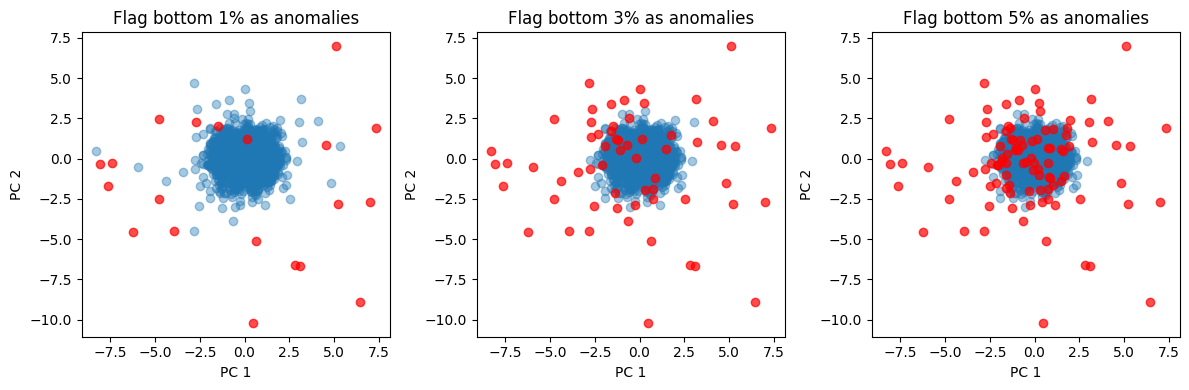

In [20]:
# Compare different anomaly thresholds
percentiles = [1, 3, 5]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, p in zip(axes, percentiles):
    thresh = np.percentile(scores, p)
    flagged = scores <= thresh

    ax.scatter(
        X_fraud_pca[~flagged, 0],
        X_fraud_pca[~flagged, 1],
        alpha=0.4
    )
    ax.scatter(
        X_fraud_pca[flagged, 0],
        X_fraud_pca[flagged, 1],
        c="red",
        alpha=0.7
    )
    ax.set_title(f"Flag bottom {p}% as anomalies")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

plt.tight_layout()
plt.show()


### Interpreting the Effect of the Anomaly Threshold

This figure shows how the set of flagged anomalies changes as we adjust the
**decision threshold** used by the anomaly detection model.

Here, we flag:
- the **bottom 1%** of anomaly scores (most conservative)
- the **bottom 3%**
- the **bottom 5%** (most aggressive)

All three panels use the same PCA projection to support visual comparison.

#### What to notice

Several trends are immediately apparent:

- **1% threshold**
  - Only the most extreme points are flagged
  - Most anomalies lie far from the dense central region
  - Very few points near the core are flagged

- **3% threshold**
  - More points are flagged around the periphery
  - Some points closer to the dense region are now included
  - The boundary between normal and anomalous becomes fuzzier

- **5% threshold**
  - Many more points are flagged
  - A noticeable number of points overlap with dense regions
  - The distinction between “normal” and “anomalous” is increasingly ambiguous

As the threshold increases, the model becomes **less selective**.

#### Why this happens

Anomaly detection models produce **continuous scores**, not binary truths.

The threshold determines:
- how cautious or aggressive the system is
- how many points are prioritized for review
- where we draw an inherently subjective line

The underlying model has **not changed** —
only our tolerance for unusual behavior has.

#### False Positives vs False Negatives

Choosing an anomaly threshold is a **business decision**, not a purely technical one.

- Lower threshold → fewer anomalies flagged
  - fewer false positives
  - more false negatives

- Higher threshold → more anomalies flagged
  - more false positives
  - fewer false negatives

In unsupervised learning, **there is no single correct answer**.
Context determines what trade-offs matter.

#### Big picture takeaway

Anomaly detection does not answer:
> *“Is this point bad?”*

It answers:
> *“How urgently should we look at this point?”*

Choosing a threshold is therefore a **decision-making step**, not a purely technical one.

In the next section, we will compare how *different anomaly detection models*
flag different points — even when given the same threshold.


### Key Takeaways

- Classical anomaly detection assigns **scores**, not labels
- Threshold choice directly affects outcomes
- Visualization helps interpretation, not validation

Next, we explore **representation-based anomaly detection**,
where anomalies are identified by how poorly they are reconstructed.


## 4.5b Representation-Based Anomaly Detection *(Optional Deep Dive)*

An alternative view of anomaly detection is **reconstruction**.

Instead of asking:
> *“Is this point isolated?”*

we ask:
> *“Can a compact representation explain this point well?”*


In [21]:
# Prepare fraud-like dataset (same preprocessing as before)
X_fraud = df_fraud.copy()
X_fraud = X_fraud.fillna(X_fraud.mean())

scaler = StandardScaler()
X_fraud_scaled = scaler.fit_transform(X_fraud)


We again use:
- missing value handling
- feature scaling

This ensures reconstruction error reflects *structure*, not scale.


### Reconstruction Error Intuition

Representation-based anomaly detection works by asking a different question:

> *Can this observation be well explained by a compact representation of the data?*

- PCA learns a **low-dimensional representation** of typical patterns
- Normal points are reconstructed well from this representation
- Unusual points deviate from learned structure and reconstruct poorly

The **reconstruction error** measures how much information is lost when a point
is compressed and then reconstructed.

This error becomes an **anomaly score**:
- low error → typical behavior
- high error → potentially anomalous behavior


In [22]:
# Fit PCA with reduced dimensionality
pca_recon = PCA(n_components=2, random_state=SEED)
X_low = pca_recon.fit_transform(X_fraud_scaled)

# Reconstruct back to original space
X_recon = pca_recon.inverse_transform(X_low)

# Compute reconstruction error (per point)
recon_error = ((X_fraud_scaled - X_recon) ** 2).mean(axis=1)

recon_error[:10]


array([0.62350559, 0.3694065 , 0.56653647, 0.38034913, 0.40851856,
       0.26169573, 0.09045048, 0.54312792, 0.36826887, 0.57986387])

### Interpreting Reconstruction Error Values

The output above shows the **reconstruction error for individual observations**.

Each value represents:
- the average squared difference between the original features
- and the reconstructed features after PCA compression

Key points to understand:

- **Each value corresponds to one observation**
- Larger values indicate **poorer reconstruction**
- Smaller values indicate **better reconstruction**

At this stage:
- these values are *relative*, not absolute
- there is no inherent cutoff between “normal” and “anomalous”

The reconstruction error becomes meaningful only when we:
- compare values across observations
- visualize their distribution
- choose a threshold to flag unusually large errors

In the next step, we will visualize these reconstruction errors
to see how they relate to the overall structure of the data.


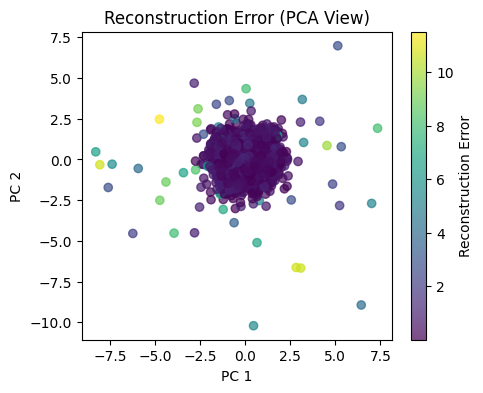

In [23]:
# Visualize reconstruction error in PCA space
plt.figure(figsize=(5, 4))
sc = plt.scatter(
    X_low[:, 0],
    X_low[:, 1],
    c=recon_error,
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(sc, label="Reconstruction Error")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Reconstruction Error (PCA View)")
plt.show()


### Interpreting Reconstruction Error (PCA View)

This plot visualizes **reconstruction error** for each observation,
colored by how poorly the point is reconstructed after PCA compression.

- Darker colors indicate **low reconstruction error**
- Brighter colors indicate **high reconstruction error**

As before, the PCA projection is used **only for visualization**.
Reconstruction error is computed in the **original feature space**.

#### What to notice

Several patterns stand out:

- Most points in the dense central region have **low reconstruction error**
- Points farther from the core tend to have **higher reconstruction error**
- High-error points appear in multiple directions, not just one
- There is no sharp boundary separating “normal” from “anomalous” points

This suggests that anomalies, under this definition, are points
that **do not conform well to the dominant patterns** learned by PCA.

#### Why this happens

PCA learns a compact representation that captures
the most common variance patterns in the data.

- Points that align with these patterns reconstruct well
- Points that deviate from them lose more information during compression

High reconstruction error therefore indicates that:
- a point does not fit the learned low-dimensional structure
- its behavior is atypical relative to the majority of the data

Importantly, this definition of “unusual” is **pattern-based**, not distance-based.

#### How this differs from Isolation Forest

- **Isolation Forest** flags points that are easy to separate
- **Reconstruction-based methods** flag points that are hard to represent compactly

As a result:
- some points flagged by one method may not be flagged by the other
- disagreement between methods is expected, not a failure

#### Big picture takeaway

Reconstruction error provides a **different lens on abnormality**.

Rather than asking:
> *“Is this point isolated?”*

it asks:
> *“Does this point fit the dominant structure of the data?”*

This perspective is especially useful when anomalies are subtle
and embedded within dense regions rather than far away from them.

In the next step, we will compare which points are flagged
by different anomaly detection methods and examine the implications
of those differences.


Points with **higher reconstruction error** appear darker.
These are candidates for anomalies.

Notice:
- some high-error points lie near clusters
- others sit on the fringes

Representation-based methods do not rely on isolation alone.


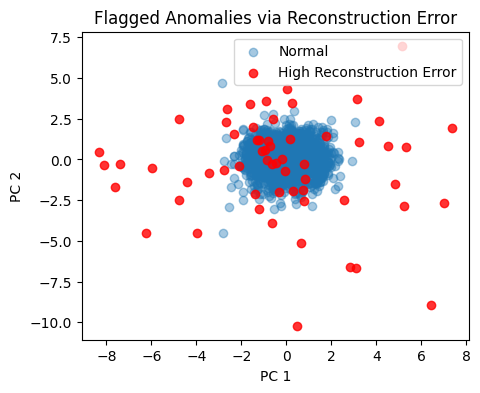

In [24]:
# Flag top reconstruction-error points
threshold = np.percentile(recon_error, 97)
flagged = recon_error >= threshold

plt.figure(figsize=(5, 4))
plt.scatter(
    X_low[~flagged, 0],
    X_low[~flagged, 1],
    alpha=0.4,
    label="Normal"
)
plt.scatter(
    X_low[flagged, 0],
    X_low[flagged, 1],
    c="red",
    alpha=0.8,
    label="High Reconstruction Error"
)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Flagged Anomalies via Reconstruction Error")
plt.legend()
plt.show()


### Interpreting Flagged Anomalies via Reconstruction Error

This plot shows which observations are flagged as anomalous
based on **high reconstruction error**, using PCA as a representation model.

- **Blue points** represent observations with low reconstruction error
- **Red points** represent observations with high reconstruction error

As before, the PCA projection is used **only for visualization**.
Anomaly scores are computed in the **original feature space**.

#### What to notice

Several important patterns emerge:

- Many high-error points lie **outside the dense central region**
- Some high-error points appear **embedded within the main cloud**
- Not all visually isolated points are flagged
- Not all flagged points are visually extreme

This immediately suggests that reconstruction-based anomalies
are **not defined purely by distance or isolation**.

#### How this compares to Isolation Forest

Comparing this plot to the Isolation Forest results:

- Some anomalies overlap across both methods
- Others are flagged by **only one method**
- Reconstruction-based methods tend to flag points that:
  - deviate from dominant patterns
  - are difficult to compress, even if nearby other points

In contrast:
- Isolation Forest emphasizes separability and isolation
- Reconstruction error emphasizes *fit to learned structure*

Neither approach is universally better —
they reflect **different definitions of “unusual.”**

#### Why disagreement is expected

Unsupervised anomaly detection does not have a single objective truth.

Each method encodes assumptions about:
- what “normal” means
- how deviation should be measured
- which patterns matter most

Disagreement between methods is therefore:
- expected
- informative
- a signal that interpretation is required

#### Big picture takeaway

This comparison reinforces a central lesson of unsupervised learning:

> *Anomalies are not discovered — they are defined.*

Different models surface different risks.
Choosing between them requires understanding:
- the data
- the model assumptions
- and the consequences of acting on those signals

In the next section, we will step back and examine
how these choices affect evaluation and decision-making
when ground-truth labels are available.


### Optional: Autoencoders (Conceptual Only)

Autoencoders generalize this idea using neural networks:
- encoder learns a compressed representation
- decoder reconstructs the input
- reconstruction error signals anomalies

The **core idea is identical** to what we just saw with PCA —
only the representation is more flexible.

Because autoencoders add complexity and hyperparameters,
we treat them as an **optional extension**, not a default tool.


### Key Takeaways

- Representation-based anomaly detection measures **fit**, not isolation
- Reconstruction error provides an interpretable anomaly score
- Different methods surface different types of anomalies

Next, we examine how to **evaluate unsupervised results**
when metrics and intuition disagree.


## 4.6 Evaluation in Unsupervised Learning

Evaluating unsupervised models is fundamentally different from supervised learning.

There is:
- no single “correct” answer
- no guaranteed ground truth
- no universally reliable metric

Instead, we rely on **proxies** and **judgment**.


In [25]:
# Prepare clustering data
X = df_blobs.dropna().values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


We reuse the blob-like dataset to keep structure visually interpretable
while examining how evaluation metrics behave.


In [26]:
# Compare clustering metrics for different values of k
ks = [2, 3, 4, 5, 6]

sil_scores = []
db_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=SEED)
    labels = km.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    
    sil_scores.append(sil)
    db_scores.append(db)

sil_scores, db_scores


([0.42412041954921226,
  0.7055571689052939,
  0.7123092884777263,
  0.6410876707954534,
  0.5025815049225627],
 [0.9269172148367445,
  0.40672775756449275,
  0.5336162418141299,
  0.6199588923804751,
  0.6877456567518463])

### Interpreting Unsupervised Evaluation Metrics

The output above shows two commonly used **unsupervised clustering metrics**
computed across different values of `k`:

- **Silhouette Score** (higher is better)
- **Davies–Bouldin Index** (lower is better)

Each metric reflects a *different definition* of clustering quality.

#### What the metrics suggest

From the values shown:

- **Silhouette Score**
  - Increases substantially from the smallest value of `k`
  - Peaks around the middle values
  - Then begins to decline as clusters are further subdivided

- **Davies–Bouldin Index**
  - Is relatively high for very small `k`
  - Reaches its lowest value at a different `k` than the silhouette score
  - Then increases again as clusters become less distinct

Importantly, **the two metrics do not agree on the “best” value of `k`.**

#### Why these metrics disagree

This disagreement is not a bug — it reflects the fact that the metrics
measure **different properties**:

- **Silhouette Score**
  - Emphasizes separation between clusters
  - Rewards compact, well-separated groups

- **Davies–Bouldin Index**
  - Emphasizes similarity between clusters
  - Penalizes clusters that are close together or overlapping

A clustering that looks good under one criterion
may look less impressive under another.

#### What this tells us about evaluation

This result reinforces a key lesson of unsupervised learning:

> *Evaluation metrics do not reveal truth — they reflect priorities.*

At this point:
- there is no objective “correct” clustering
- choosing `k` depends on what you value
- different metrics encode different assumptions

#### Big picture takeaway

Unsupervised evaluation metrics are **diagnostic tools**, not decision-makers.

They can:
- highlight instability
- flag extreme cases
- support comparisons

But they cannot replace:
- visual inspection
- domain knowledge
- reasoning about consequences

In the next step, we will compare these metric-driven suggestions
to visual intuition and ask which results we would actually trust.


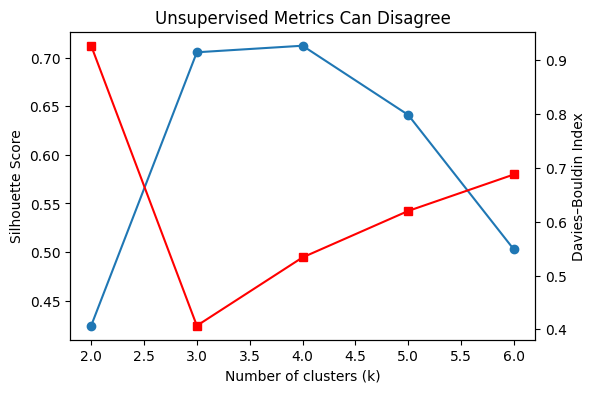

In [27]:
# Plot metric trends
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(ks, sil_scores, marker="o")
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Silhouette Score")

ax2 = ax1.twinx()
ax2.plot(ks, db_scores, marker="s", color="red")
ax2.set_ylabel("Davies–Bouldin Index")

plt.title("Unsupervised Metrics Can Disagree")
plt.show()


Notice that:
- one metric may prefer smaller `k`
- another may prefer larger `k`

There is no guarantee they will agree — or align with what *looks* reasonable.


### Interpreting the “Best” Clustering According to Metrics

This figure summarizes how two unsupervised evaluation metrics change
as we vary the number of clusters `k`:

- **Silhouette Score** (blue, higher is better)
- **Davies–Bouldin Index** (red, lower is better)

Both metrics are computed on the same data, using the same clustering algorithm.

#### What to notice

Several important patterns stand out:

- The **silhouette score** reaches its maximum at an intermediate value of `k`
- The **Davies–Bouldin index** reaches its minimum at a *different* value of `k`
- As `k` increases beyond this point:
  - silhouette score begins to decline
  - Davies–Bouldin index begins to rise

In other words, **the metrics disagree about what “best” means**.

#### Why this matters

If we were to choose `k` purely based on metrics:
- one metric would suggest a certain number of clusters
- another would suggest a different choice

Neither metric is “wrong.”
Each encodes a different notion of quality:
- separation vs. compactness
- global vs. local structure

This creates an unavoidable decision point.

#### Metrics vs. visual intuition

When we compare these metric-driven recommendations
to the visualizations we examined earlier, we may notice that:

- the clustering with the highest silhouette score
  does not necessarily look more meaningful
- some splits favored by metrics may feel arbitrary
- additional clusters may improve a score without improving interpretability

This highlights a key limitation:
**metrics optimize mathematical criteria, not understanding.**

#### Big picture takeaway

This example reinforces the central message of unsupervised evaluation:

> *Metrics can guide decisions, but they cannot make them for us.*

Choosing a model or parameter value requires:
- understanding what the metric measures
- recognizing what it ignores
- and weighing those trade-offs in context

In real applications, the “best” clustering is often the one that:
- aligns with domain knowledge
- supports downstream decisions
- and balances simplicity with usefulness

This is why unsupervised learning always requires
human judgment alongside quantitative evaluation.


### When Metrics and Intuition Conflict

A clustering can:
- score well numerically
- look unintuitive visually

This does **not** mean the metric is “wrong”.
It means the metric measures something *different* than human perception.


Even when a clustering scores best under a given metric,
that result may not align with human intuition or downstream usefulness.


### Key Takeaways

- Unsupervised evaluation relies on **proxy metrics**
- Different metrics capture different notions of quality
- Metrics can and do disagree
- Visual inspection remains essential
- Domain context ultimately determines usefulness

In the final section, you will apply these ideas in a **hands-on capstone**
and decide which methods you would trust in a real application.
